# Eye Gaze Analysis and Visualization

This notebook loads **pre-processed eye tracking metrics** and performs statistical analysis and visualization.

**Prerequisites**: 
- Run `process_eye_data.py` first to generate processed metrics
- Install R and required packages for statistical analysis:
  - `lmerTest` (for mixed-effects modeling)
  - `emmeans` (for estimated marginal means and pairwise comparisons)

**Data Source**: Loads from `data/processed/combined/eyegaze_metrics_all.csv`

## 1. Import Libraries and Load Pre-Processed Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Data Processing Demonstration

Before analyzing the pre-processed metrics, let's visualize what the processing pipeline does by loading a random raw file and showing the normalization step:

In [2]:
# Import processing utilities to demonstrate the pipeline
from utils.config import CFG
from utils.eye_gaze_utils import load_file_data, normalize_gaze_to_screen, plot_data
import random

print("✓ Processing utilities imported")

✓ Processing utilities imported


Loading random file for demonstration: 3244_session01.csv
✓ Loaded 459600 samples
✓ Normalized gaze coordinates to screen dimensions (2560x1440)
Plotting data...


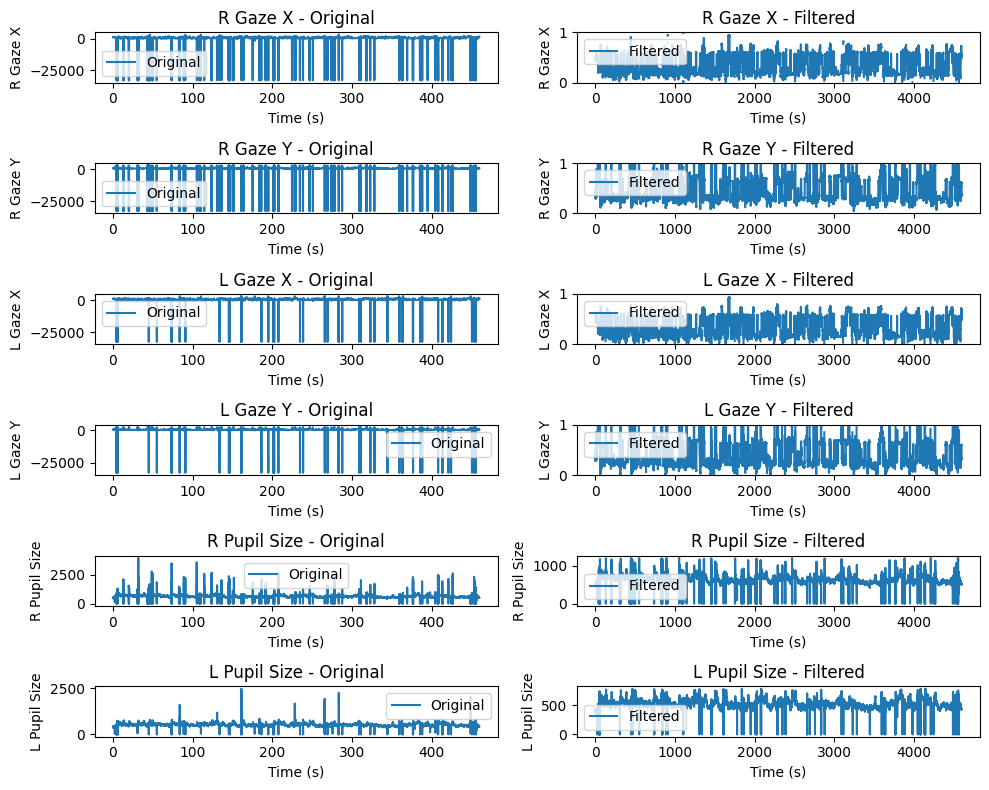

In [3]:
# Pick a random raw file to demonstrate processing
raw_dir = Path(CFG.RAW_DIR)
eye_files = sorted([f.name for f in raw_dir.glob("*.csv")])

if len(eye_files) > 0:
    # Pick a random file
    example_file = random.choice(eye_files)
    print(f"Loading random file for demonstration: {example_file}")
    
    # Load and normalize data
    file_data = load_file_data(str(raw_dir), example_file)
    
    if file_data is not None:
        original_df = file_data['data']
        filtered_df = normalize_gaze_to_screen(original_df.copy())
        print(f"✓ Loaded {len(original_df)} samples")
        print(f"✓ Normalized gaze coordinates to screen dimensions ({CFG.SCREEN_WIDTH}x{CFG.SCREEN_HEIGHT})")
        
        # Plot original versus normalized data
        columns_to_plot = ['R Gaze X', 'R Gaze Y', 'L Gaze X', 'L Gaze Y', 'R Pupil Size', 'L Pupil Size']
        plot_data(original_df, filtered_df, columns_to_plot, filename=example_file, dir=str(raw_dir), save=False)
    else:
        print(f"Failed to load {example_file}")
else:
    print("No raw files found in directory")

## 3. Load Pre-Processed Metrics

Load the combined eye tracking metrics file (generated by `process_eye_data.py`):

In [4]:
# Load combined metrics from processed data
metrics_file = Path('data/processed/combined/eyegaze_metrics_all.csv')

if not metrics_file.exists():
    raise FileNotFoundError(
        f"Processed metrics file not found: {metrics_file}\n"
        "Please run 'python process_eye_data.py' first to generate the metrics."
    )

all_metrics_df = pd.read_csv(metrics_file)

print(f"✓ Loaded {len(all_metrics_df)} windows from {all_metrics_df['participant'].nunique()} participants")
print(f"✓ Conditions: {sorted(all_metrics_df['condition'].unique())}")
print(f"✓ Windows per participant: {all_metrics_df.groupby('participant').size().describe()}")

✓ Loaded 1875 windows from 43 participants
✓ Conditions: ['H', 'L', 'M']
✓ Windows per participant: count    43.000000
mean     43.604651
std       3.381600
min      30.000000
25%      44.000000
50%      45.000000
75%      45.000000
max      45.000000
dtype: float64


## 4. Explore the Data

Display the first few rows and summary statistics:

In [5]:
# Display first few rows
print("First 10 rows of the dataset:")
display(all_metrics_df.head(10))

# Display summary statistics
print("\nSummary statistics:")
display(all_metrics_df.describe())

# Display data types and missing values
print("\nData info:")
print(f"Shape: {all_metrics_df.shape}")
print(f"Columns: {list(all_metrics_df.columns)}")
print(f"\nMissing values per column:")
print(all_metrics_df.isnull().sum())

First 10 rows of the dataset:


,participant,condition,window_index,start_time,end_time,pct_missing,mean_vel,max_vel,mean_acc,rms_disp,fix_count,fix_mean_dur,fix_rate,blink_count,blink_mean_dur,blink_rate,sac_count,sac_mean_dur,sac_rate
0,3105,H,0,0.000000,59.999401,5.577578,1.796323,459.230004,0.011924,0.348134,63,0.369807,1.050010,121,0.054433,2.016687,2267,0.002422,37.783711
1,3105,H,1,30.000792,89.999283,0.645464,1.628242,669.950666,0.271897,0.310204,90,0.332763,1.500038,172,0.016956,2.866739,2524,0.002406,42.067725
2,3105,H,2,60.000438,119.999061,0.830114,1.584373,669.950666,0.144381,0.309980,100,0.319974,1.666705,146,0.013503,2.433389,2657,0.002394,44.284350
3,3105,H,3,90.000347,149.999007,1.522958,1.677965,707.694238,0.165085,0.310242,95,0.330647,1.583369,144,0.019596,2.400054,2956,0.002369,49.267766
4,3105,H,4,120.000105,179.999512,2.138626,1.836662,707.694238,0.212467,0.306532,103,0.324144,1.716684,193,0.020323,3.216698,3018,0.002372,50.300497
5,3105,H,5,150.000047,209.999311,1.542963,1.868196,677.872665,0.131431,0.310773,115,0.317921,1.916690,106,0.028506,1.766688,3020,0.002373,50.333951
6,3105,H,6,180.000552,239.999299,1.634635,1.824972,539.050587,0.127828,0.309055,106,0.335286,1.766704,120,0.027309,2.000042,3218,0.002359,53.634453
7,3105,H,7,210.000353,269.999025,3.162695,1.855625,539.050587,0.263731,0.311693,105,0.335007,1.750039,123,0.032763,2.050045,3375,0.002363,56.251245
8,3105,H,8,240.000340,299.999345,2.956994,2.018123,454.241642,0.208084,0.306812,112,0.311224,1.866698,63,0.055855,1.050017,3226,0.002382,53.767558
9,3105,H,9,270.000063,329.999083,1.478141,2.462742,516.913344,-0.058070,0.295468,110,0.316539,1.833363,50,0.058384,0.833347,3105,0.002378,51.750845



Summary statistics:


,participant,window_index,start_time,end_time,pct_missing,mean_vel,max_vel,mean_acc,rms_disp,fix_count,fix_mean_dur,fix_rate,blink_count,blink_mean_dur,blink_rate,sac_count,sac_mean_dur,sac_rate
count,1875.000000,1875.000000,1875.000000,1875.000000,1875.000000,1875.000000,1875.000000,1875.000000,1875.000000,1875.000000,1875.000000,1875.000000,1875.000000,1875.000000,1875.000000,1875.000000,1875.000000,1875.000000
mean,3226.370133,7.011733,210.352486,270.351470,8.225256,1.597763,322.207551,-0.005155,0.323832,79.385600,0.359487,1.323116,34.393067,0.115728,0.573227,3003.841067,0.002359,50.064868
std,22.769542,4.301457,129.043749,129.043701,5.695283,0.424334,200.223897,0.180425,0.020008,19.504894,0.056834,0.325087,25.601716,0.063704,0.426703,697.304164,0.000049,11.621944
min,3105.000000,0.000000,0.000000,59.998955,0.026076,0.911800,48.732151,-1.796736,0.205253,10.000000,0.224450,0.166669,2.000000,0.010237,0.033334,1513.000000,0.002269,25.216831
25%,3218.000000,3.000000,90.000789,149.999781,3.301431,1.332485,158.465501,-0.085462,0.312410,69.000000,0.320664,1.150008,18.000000,0.072435,0.300007,2507.000000,0.002322,41.783678
50%,3229.000000,7.000000,210.000502,269.999410,7.405413,1.494509,265.497568,-0.007850,0.324866,82.000000,0.352185,1.366691,28.000000,0.102191,0.466676,2913.000000,0.002351,48.550394
75%,3240.000000,11.000000,330.000256,389.999211,12.501855,1.726241,459.696749,0.071838,0.337385,93.000000,0.389860,1.550022,43.000000,0.142185,0.716675,3413.000000,0.002388,56.884540
max,3250.000000,14.000000,420.001040,479.999994,24.457940,5.112911,1088.332537,1.920988,0.390970,125.000000,0.952041,2.083382,329.000000,0.521914,5.483484,5274.000000,0.002597,87.900786



Data info:
Shape: (1875, 19)
Columns: ['participant', 'condition', 'window_index', 'start_time', 'end_time', 'pct_missing', 'mean_vel', 'max_vel', 'mean_acc', 'rms_disp', 'fix_count', 'fix_mean_dur', 'fix_rate', 'blink_count', 'blink_mean_dur', 'blink_rate', 'sac_count', 'sac_mean_dur', 'sac_rate']

Missing values per column:
participant       0
condition         0
window_index      0
start_time        0
end_time          0
                 ..
blink_mean_dur    0
blink_rate        0
sac_count         0
sac_mean_dur      0
sac_rate          0
Length: 19, dtype: int64


## 5. Condition-Level Summary Statistics

Compute mean and standard error for each metric by condition:

In [6]:
# Compute summary statistics by condition (using actual column names)
summary_stats = all_metrics_df.groupby('condition').agg({
    'blink_count': ['mean', 'std', 'sem'],
    'blink_rate': ['mean', 'std', 'sem'],
    'fix_count': ['mean', 'std', 'sem'],
    'fix_rate': ['mean', 'std', 'sem'],
    'sac_count': ['mean', 'std', 'sem'],
    'sac_rate': ['mean', 'std', 'sem'],
    'mean_vel': ['mean', 'std', 'sem'],
    'rms_disp': ['mean', 'std', 'sem']
}).round(3)

print("Summary Statistics by Condition:")
display(summary_stats)

# Also show counts by participant and condition
print("\nWindows per Participant and Condition:")
window_counts = all_metrics_df.groupby(['participant', 'condition']).size().unstack(fill_value=0)
display(window_counts.describe())

Summary Statistics by Condition:


blink_count                blink_rate               fix_count  \
                 mean     std    sem       mean    std    sem      mean   
condition                                                                 
H              39.954  28.056  1.113      0.666  0.468  0.019    78.420   
L              29.073  19.156  0.773      0.485  0.319  0.013    80.718   
M              33.970  27.340  1.093      0.566  0.456  0.018    79.058   

                         fix_rate               sac_count                   \
              std    sem     mean    std    sem      mean      std     sem   
condition                                                                    
H          20.528  0.815    1.307  0.342  0.014  3054.195  695.478  27.599   
L          16.524  0.667    1.345  0.275  0.011  2967.002  707.944  28.570   
M          21.039  0.841    1.318  0.351  0.014  2988.896  686.711  27.446   

          sac_rate                mean_vel               rms_disp         \
              mean     std    sem     mean    std    sem     mean    std   
condition                                                                  
H           50.904  11.592  0.460    1.655  0.438  0.017    0.326  0.020   
L           49.451  11.799  0.476    1.530  0.377  0.015    0.321  0.022   
M           49.816  11.445  0.457    1.606  0.446  0.018    0.324  0.018   

                  
             sem  
condition         
H          0.001  
L          0.001  
M          0.001


Windows per Participant and Condition:


condition,H,L,M
count,43.000000,43.000000,43.000000
mean,14.767442,14.279070,14.558140
std,0.648706,2.797325,1.419294
min,12.000000,0.000000,7.000000
25%,15.000000,15.000000,15.000000
50%,15.000000,15.000000,15.000000
75%,15.000000,15.000000,15.000000
max,15.000000,15.000000,15.000000


## 6. Add Session Order Information for Statistical Analysis

Load participant info and add session order variables needed for mixed effects models:

In [7]:
# Load participant info to get session order (using pose utilities)
import sys
sys.path.append('..')
from Pose.utils.io_utils import load_participant_info_file

# Load participant info file
participant_info_path = load_participant_info_file()
participant_info = pd.read_csv(participant_info_path)

print(f"✓ Loaded participant info from: {participant_info_path}")

# Create session_order column (e.g., "LMH", "LHM")
if {"session01", "session02", "session03"}.issubset(participant_info.columns):
    participant_info["session_order"] = (
        participant_info["session01"].str[0] +
        participant_info["session02"].str[0] +
        participant_info["session03"].str[0]
    )
    
    # Map session_order to numeric values
    session_order_numeric_map = {
        "LMH": 1, 
        "LHM": 2, 
        "MLH": 3, 
        "MHL": 4, 
        "HLM": 5, 
        "HML": 6
    }
    
    participant_info["session_order_numeric"] = participant_info["session_order"].map(session_order_numeric_map)
    
    # Create a mapping from participant ID to session_order_numeric
    session_order_map = participant_info.set_index("Participant ID")["session_order_numeric"].to_dict()
    
    # Add session_order_numeric to all_metrics_df
    all_metrics_df["session_order_numeric"] = all_metrics_df["participant"].astype(int).map(session_order_map)
    
    print(f"✓ Added session order information")
    print(f"  Unique session orders: {sorted(participant_info['session_order'].unique())}")
    print(f"  Session order distribution:")
    print(participant_info['session_order'].value_counts().sort_index())
else:
    raise ValueError("Participant info file missing required columns: session01, session02, session03")

✓ Loaded participant info from: D:\Onedrive\Macquarie University\Complexity in Action - Mind and Interaction Dynamics\PNAS-MATB\participant_info.csv
✓ Added session order information
  Unique session orders: ['---', 'LHM', 'LMH']
  Session order distribution:
session_order
---     1
LHM    24
LMH    25
Name: count, dtype: int64


## 7. Statistical Analysis Using Linear Mixed Effects Models

Run mixed effects models and create visualizations for key metrics:

In [8]:
import sys
sys.path.append('..')  # Add parent directory
from stats_utils.stats_figures import run_rpy2_lmer, barplot_ax

# Define relevant metrics and labels for statistical analysis
metrics = [
    ("blink_count", "Blink Count (per window)"),
    ("fix_count", "Fixation Count (per window)"),
    ("sac_count", "Saccade Count (per window)"),
    ("blink_rate", "Blink Rate (per second)"),
    ("fix_rate", "Fixation Rate (per second)"),
    ("sac_rate", "Saccade Rate (per second)"),
    ("mean_vel", "Mean Velocity (deg/sec)"),
    ("rms_disp", "RMS Dispersion (deg)")
]

print("✓ Imported statistical utilities")

Error importing in API mode: ImportError('On Windows, cffi mode "ANY" is only "ABI".')
Trying to import in ABI mode.


✓ Imported statistical utilities


R callback write-console: Loading required package: lme4
  
R callback write-console: Loading required package: Matrix
  



Blink Count (per window)
Means for blink_count:
  H: 39.954
  L: 29.073
  M: 33.970


R callback write-console: 
Attaching package: 'lmerTest'

  
R callback write-console: The following object is masked from 'package:lme4':

    lmer

  
R callback write-console: The following object is masked from 'package:stats':

    step

  
R callback write-console: Welcome to emmeans.
Caution: You lose important information if you filter this package's results.
See '? untidy'
  



=== Blink Count (per window) (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: 16793.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.0665 -0.4784 -0.1195  0.2957 13.4959 

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 207.2    14.39   
 Residual                   426.1    20.64   
Number of obs: 1875, groups:  participant_id, 43

Fixed effects:
                       Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)             43.7868     7.4384   41.9469   5.887 5.81e-07 ***
condition.L              7.4672     0.8293 1830.8158   9.005  < 2e-16 ***
condition.Q              0.3863     0.8278 1830.3094   0.467    0.641    
session_order_numeric   -6.5260     4.5237   41.0407  -1.443    0.157    
window_index             0.130

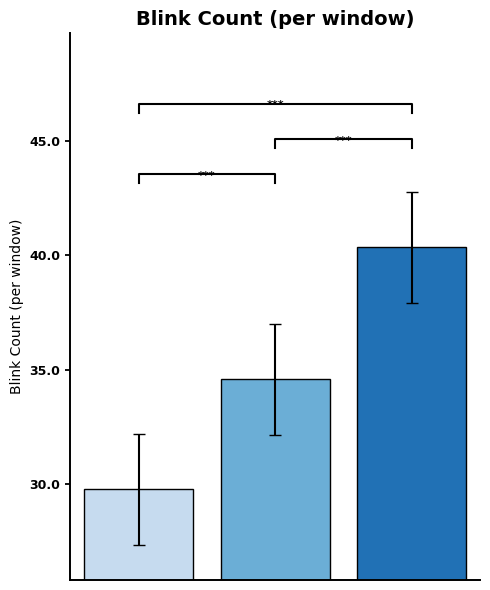


Fixation Count (per window)
Means for fix_count:
  H: 78.420
  L: 80.718
  M: 79.058

=== Fixation Count (per window) (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: 14441.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.7630 -0.6155 -0.0009  0.6338  4.6340 

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 265.6    16.30   
 Residual                   117.2    10.83   
Number of obs: 1875, groups:  participant_id, 43

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)             71.02996    8.23665   41.20934   8.624 8.99e-11 ***
condition.L             -1.83664    0.43505 1829.41863  -4.222 2.54e-05 ***
condition.Q              0.76379    0.43426 1829.29909   1.759   0.0788 .  
session

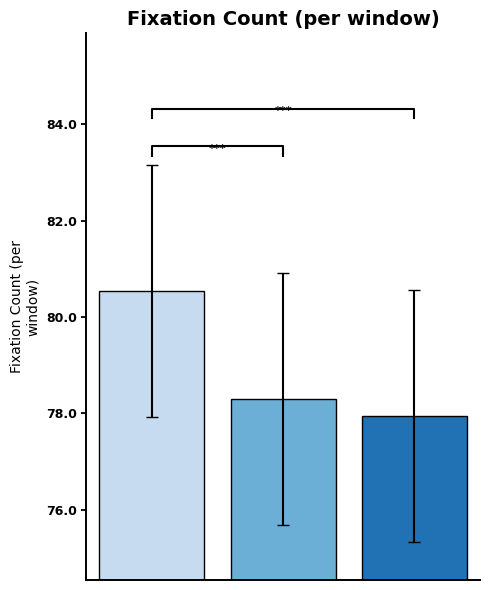


Saccade Count (per window)
Means for sac_count:
  H: 3054.195
  L: 2967.002
  M: 2988.896

=== Saccade Count (per window) (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: 27081.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.6047 -0.5918 -0.0295  0.5555  4.5485 

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 408186   638.9   
 Residual                    99804   315.9   
Number of obs: 1875, groups:  participant_id, 43

Fixed effects:
                      Estimate Std. Error       df t value Pr(>|t|)    
(Intercept)           2886.464    321.970   41.099   8.965 3.20e-11 ***
condition.L             86.600     12.694 1829.217   6.822 1.21e-11 ***
condition.Q             -7.273     12.670 1829.150  -0.574    0.566    
session_order_numer

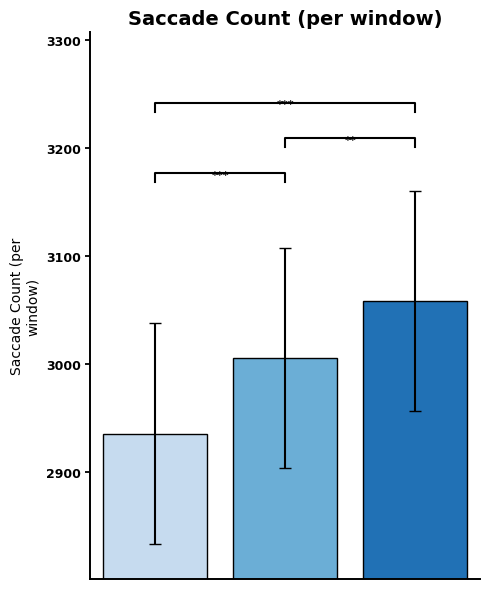


Blink Rate (per second)
Means for blink_rate:
  H: 0.666
  L: 0.485
  M: 0.566

=== Blink Rate (per second) (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: 1480.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.0665 -0.4784 -0.1195  0.2958 13.4960 

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 0.05755  0.2399  
 Residual                   0.11838  0.3441  
Number of obs: 1875, groups:  participant_id, 43

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)            7.298e-01  1.240e-01  4.195e+01   5.887 5.81e-07 ***
condition.L            1.245e-01  1.382e-02  1.831e+03   9.005  < 2e-16 ***
condition.Q            6.439e-03  1.380e-02  1.830e+03   0.467    0.641    
session_order_nume

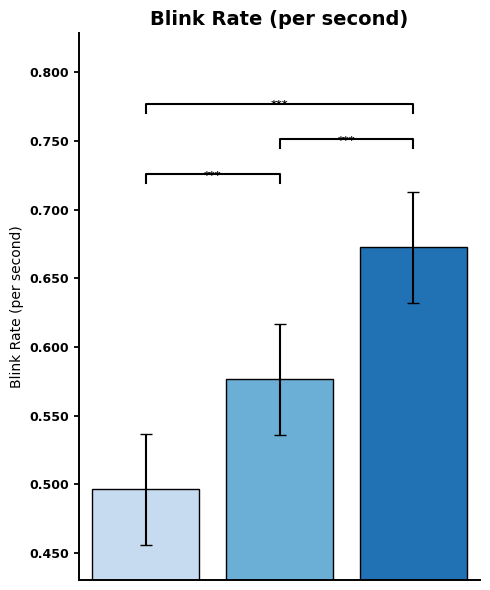


Fixation Rate (per second)
Means for fix_rate:
  H: 1.307
  L: 1.345
  M: 1.318

=== Fixation Rate (per second) (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -871.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.7630 -0.6156 -0.0009  0.6338  4.6341 

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 0.07379  0.2716  
 Residual                   0.03257  0.1805  
Number of obs: 1875, groups:  participant_id, 43

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)            1.184e+00  1.373e-01  4.121e+01   8.624 8.99e-11 ***
condition.L           -3.061e-02  7.251e-03  1.829e+03  -4.222 2.54e-05 ***
condition.Q            1.273e-02  7.238e-03  1.829e+03   1.759   0.0788 .  
session_order_

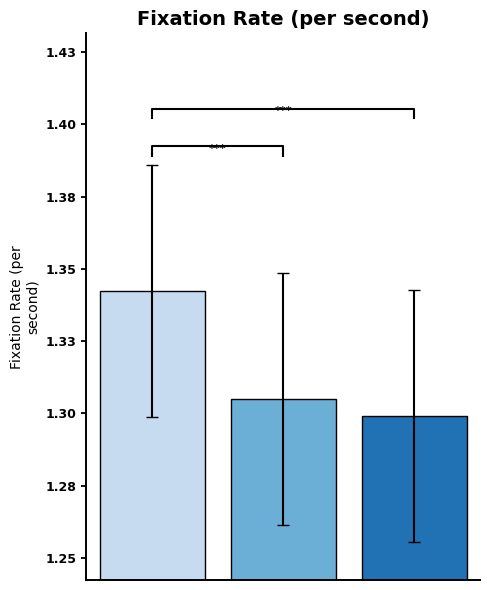


Saccade Rate (per second)
Means for sac_rate:
  H: 50.904
  L: 49.451
  M: 49.816

=== Saccade Rate (per second) (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: 11769.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.6048 -0.5918 -0.0295  0.5555  4.5486 

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 113.39   10.648  
 Residual                    27.72    5.265  
Number of obs: 1875, groups:  participant_id, 43

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)            4.811e+01  5.366e+00  4.110e+01   8.965 3.20e-11 ***
condition.L            1.443e+00  2.116e-01  1.829e+03   6.822 1.21e-11 ***
condition.Q           -1.212e-01  2.112e-01  1.829e+03  -0.574    0.566    
session_orde

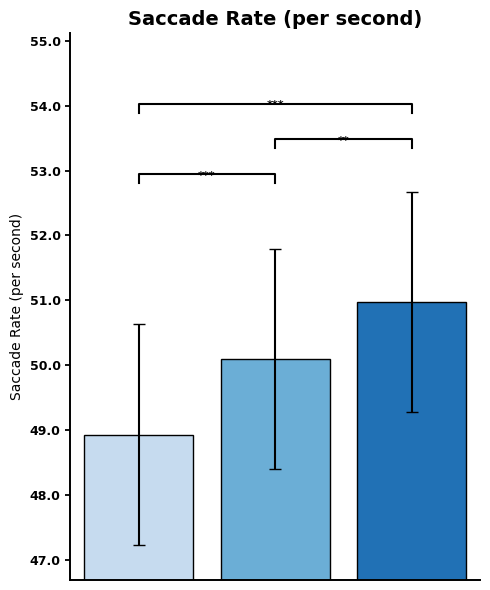


Mean Velocity (deg/sec)
Means for mean_vel:
  H: 1.655
  L: 1.530
  M: 1.606

=== Mean Velocity (deg/sec) (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: 511.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.5220 -0.4929 -0.0824  0.3369 10.4450 

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 0.10870  0.3297  
 Residual                   0.06875  0.2622  
Number of obs: 1875, groups:  participant_id, 43

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)            1.762e+00  1.671e-01  4.128e+01  10.549 2.74e-13 ***
condition.L            9.264e-02  1.053e-02  1.830e+03   8.794  < 2e-16 ***
condition.Q           -1.798e-02  1.052e-02  1.829e+03  -1.710   0.0874 .  
session_order_numeric

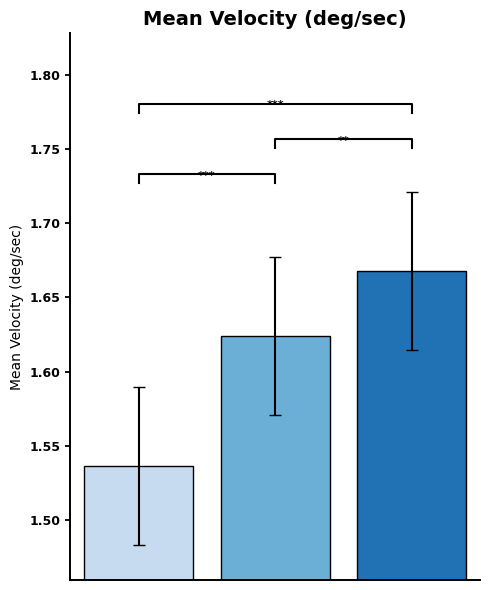


RMS Dispersion (deg)
Means for rms_disp:
  H: 0.326
  L: 0.321
  M: 0.324

=== RMS Dispersion (deg) (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -9890.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.4111 -0.5619  0.0396  0.6393  3.2456 

Random effects:
 Groups         Name        Variance  Std.Dev.
 participant_id (Intercept) 0.0001311 0.01145 
 Residual                   0.0002707 0.01645 
Number of obs: 1875, groups:  participant_id, 43

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)            3.303e-01  5.918e-03  4.183e+01  55.802  < 2e-16 ***
condition.L            2.814e-03  6.609e-04  1.831e+03   4.258 2.16e-05 ***
condition.Q           -5.501e-04  6.597e-04  1.830e+03  -0.834    0.404    
session_order_numeric 

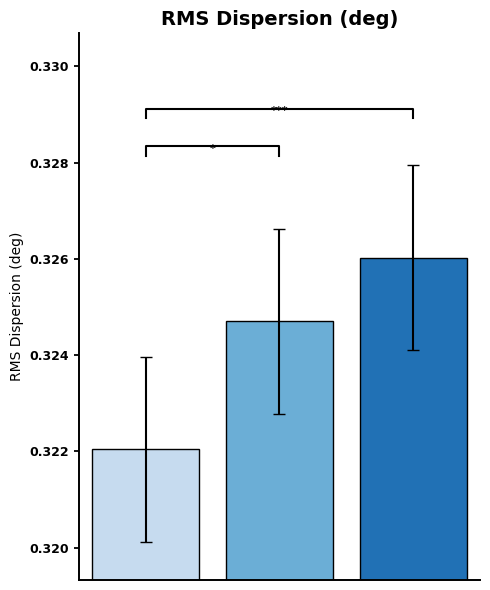


✓ Statistical analysis complete!


In [9]:
# Run statistical analysis for key metrics
for metric, label in metrics:
    print(f"\n{'='*60}")
    print(f"{label}")
    print(f"{'='*60}")
    
    # Run mixed effects model and get stats
    pairwise_p, means, cis = run_rpy2_lmer(
        all_metrics_df, metric, label
    )
    
    # Prepare data for plotting
    conds = ["L", "M", "H"]
    mean_vals = [means.get(c, float('nan')) for c in conds]
    sems = [(cis[c][1] - cis[c][0]) / 3.92 if c in cis else float('nan') for c in conds]  # 95% CI to SEM
    pvals = [
        pairwise_p.get(("L", "M"), 1.0), 
        pairwise_p.get(("L", "H"), 1.0), 
        pairwise_p.get(("M", "H"), 1.0)
    ]
    
    # Create plot
    fig, ax = plt.subplots(figsize=(5, 6))
    barplot_ax(ax, mean_vals, sems, pvals, ylabel=label, metric_name=metric)
    ax.set_title(label, fontsize=14, weight='bold')
    plt.tight_layout()
    plt.show()

print("\n✓ Statistical analysis complete!")